In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
import random
from PIL import ImageOps
from torchvision import transforms
def apply_invert_augmentation(image):
    inverted_image = ImageOps.invert(image)
    return inverted_image

class RandomInvert:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image):
        temp = random.random()
        if temp < self.p:
            image = apply_invert_augmentation(image)
        return image

In [5]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    RandomInvert(p=0.5),  # Apply invert filter to a subset of images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
test_transform = transforms.Compose([
    #RandomInvert(p=0.5),
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])

In [61]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)

In [75]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, 3)  # 1 input channel, 64 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(64, 64, 3)  # 64 input channels, 64 output channels, 3x3 kernel
        self.maxpool1 = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3)  # 64 input channels, 128 output channels, 3x3 kernel
        self.conv4 = nn.Conv2d(128, 128, 3)  # 128 input channels, 128 output channels, 3x3 kernel
        self.maxpool2 = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.batchnorm2 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3)  # 128 input channels, 256 output channels, 3x3 kernel
        self.maxpool3 = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 512)  # Fully connected layer
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)  # Output layer with 10 classes (0-9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)

        x = self.conv5(x)
        x = self.maxpool3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        
        return x

# Create an instance of the modified model
model = Net()


In [8]:
model

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=10,

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [67]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Move the model to the appropriate device (CPU or GPU)

model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct / total
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

Epoch [1/10], Loss: 0.3869, Accuracy: 0.8730
Epoch [2/10], Loss: 0.0775, Accuracy: 0.9767
Epoch [3/10], Loss: 0.0653, Accuracy: 0.9801
Epoch [4/10], Loss: 0.0491, Accuracy: 0.9850
Epoch [5/10], Loss: 0.0419, Accuracy: 0.9869
Epoch [6/10], Loss: 0.0411, Accuracy: 0.9874
Epoch [7/10], Loss: 0.0366, Accuracy: 0.9888
Epoch [8/10], Loss: 0.0332, Accuracy: 0.9898
Epoch [9/10], Loss: 0.0276, Accuracy: 0.9914
Epoch [10/10], Loss: 0.0271, Accuracy: 0.9912


In [76]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

model.eval() 
correct = 0
total = 0
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy:.4f}")

predictions = np.array(predictions)
true_labels = np.array(true_labels)

Accuracy on the test set: 0.9917


In [77]:
# Calculate evaluation metrics
print("Classification Report:")
report = classification_report(true_labels, predictions,output_dict=True)
report = pd.DataFrame(report).transpose()
report

Classification Report:


precision    recall  f1-score     support
0              0.995885  0.987755  0.991803    980.0000
1              0.994728  0.997357  0.996040   1135.0000
2              0.990329  0.992248  0.991288   1032.0000
3              0.994018  0.987129  0.990561   1010.0000
4              0.988900  0.997963  0.993411    982.0000
5              0.984479  0.995516  0.989967    892.0000
6              0.994759  0.990605  0.992678    958.0000
7              0.992165  0.985409  0.988775   1028.0000
8              0.994856  0.992813  0.993834    974.0000
9              0.986180  0.990089  0.988131   1009.0000
accuracy       0.991700  0.991700  0.991700      0.9917
macro avg      0.991630  0.991688  0.991649  10000.0000
weighted avg   0.991718  0.991700  0.991699  10000.0000

In [94]:
print("Confusion Matrix:")
cm = confusion_matrix(true_labels, predictions)
cm = pd.DataFrame(cm)
cm

Confusion Matrix:


0     1     2    3    4    5    6     7    8    9
0  968     0     0    0    0    1    3     1    0    7
1    0  1132     0    0    0    0    1     1    0    1
2    1     0  1024    3    0    0    0     4    0    0
3    0     0     1  997    0    7    0     1    4    0
4    0     0     0    0  980    0    0     0    0    2
5    0     0     0    2    0  888    1     0    0    1
6    3     4     0    0    1    0  949     0    1    0
7    0     2     7    0    5    0    0  1013    0    1
8    0     0     2    1    0    1    0     1  967    2
9    0     0     0    0    5    5    0     0    0  999

In [79]:
torch.save(model.state_dict(), 'model_state_dict.pth')

In [9]:
from PIL import Image
import requests
from io import BytesIO

In [13]:
temp_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


temp_model = Net()
temp_model.load_state_dict(torch.load(r'./model_state_dict.pth',map_location=torch.device('cpu')))
temp_model.eval()

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batchnorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=512, out_features=10,

In [14]:
def process_image_url(image_url):
    response = requests.get(image_url)
    img = Image.open(BytesIO(response.content)).convert('L')
    img = temp_transform(img)
    img = img.unsqueeze(0)  # Add a batch dimension
    return img

In [16]:

def predict_digit(image):
    with torch.no_grad():
        output = temp_model(image)
        probabilities = F.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, 1)
        predicted_digit = predicted_class.item()
        predicted_probability = probabilities[0, predicted_digit].item()
        return predicted_digit, predicted_probability

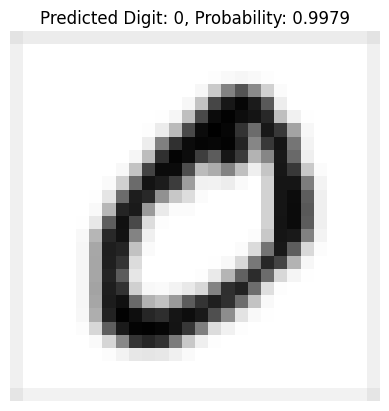

In [17]:
image_url = 'https://th.bing.com/th/id/R.f99a201e557bacdbe39190a6f913b49e?rik=V9OmtWIVtnuPgQ&riu=http%3a%2f%2fneuralnetworksanddeeplearning.com%2fimages%2fmnist_complete_zero.png&ehk=LU3qBRCEDJzfko%2bs5SpqANwd5T1MGLeUoIJO3BhXPyw%3d&risl=&pid=ImgRaw&r=0' 
image = process_image_url(image_url)
predicted_digit, predicted_probability = predict_digit(image)

# Convert the PyTorch tensor to a NumPy array and squeeze the dimensions
image = image.squeeze(0).numpy()
image = image.squeeze(0)
# Reverse the normalization transformation
image = (image * 0.5) + 0.5

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')

# Display the predicted digit and its probability
plt.title(f'Predicted Digit: {predicted_digit}, Probability: {predicted_probability:.4f}')
plt.show()

In [45]:
import pandas as pd
testset = pd.read_csv(r'test.csv')

In [46]:
testset = np.array(testset)

In [65]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
temp_model.eval()
# Transformation pipeline for preprocessing the test image
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the test set from the CSV file
test_data = pd.read_csv(r'test.csv')

# Create a new DataFrame to store the predictions
predictions_data = pd.DataFrame(columns=['predicted_digit', 'probability'])

# Iterate over the test set
for index, row in test_data.iterrows():
    pixel_values = row.values.astype(np.uint8)  

    # Reshape and preprocess the pixel values into an image
    image = np.reshape(pixel_values, (28, 28))
    image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    # Perform prediction
    with torch.no_grad():
        output = temp_model(image)
        probabilities = F.softmax(output, dim=1)
        _, predicted_class = torch.max(probabilities, 1)
        predicted_digit = predicted_class.item()
        predicted_probability = probabilities[0, predicted_digit].item()

    # Add the prediction to the DataFrame
    predictions_data = predictions_data.append({
        'predicted_digit': predicted_digit,
        'probability': predicted_probability
    }, ignore_index=True)


C:\Users\Zain\AppData\Local\Temp\ipykernel_10392\804839706.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_data = predictions_data.append({
C:\Users\Zain\AppData\Local\Temp\ipykernel_10392\804839706.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_data = predictions_data.append({
C:\Users\Zain\AppData\Local\Temp\ipykernel_10392\804839706.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_data = predictions_data.append({
C:\Users\Zain\AppData\Local\Temp\ipykernel_10392\804839706.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_data = predictions_data.append({
C:\Users\Zain\Ap

In [69]:
predictions_data[predictions_data['probability']<0.5]

predicted_digit  probability
3                  3.0     0.451506
640                8.0     0.388895
844                2.0     0.476963
1414               9.0     0.322486
2149               4.0     0.485538
2518               0.0     0.412352
2646               0.0     0.363705
4072               9.0     0.409557
4474               3.0     0.489955
4723               8.0     0.351756
5306               8.0     0.457198
5457               8.0     0.380644
7657               6.0     0.445553
8940               7.0     0.490679
9577               9.0     0.396691
9900               6.0     0.424055
10094              5.0     0.481888
10130              3.0     0.434187
10210              9.0     0.372489
10839              9.0     0.454388
12165              9.0     0.496493
13564              2.0     0.358351
14014              3.0     0.426697
15095              2.0     0.486414
15127              9.0     0.475737
15353              2.0     0.478341
15740              7.0     0.424652
16173              8.0     0.482164
16514              4.0     0.261149
18166              4.0     0.477758
18843              1.0     0.496800
20470              8.0     0.348501
22009              7.0     0.488942
22555              0.0     0.322565
23435              9.0     0.448273
27716              8.0     0.488260
27939              2.0     0.470063

In [70]:
#ImageId
predictions_data['ImageId'] = np.arange(len(predictions_data))

In [72]:
predictions_data['Label'] = predictions_data['predicted_digit']

In [76]:
predictions_data.drop(['predicted_digit','probability'],axis = 1,inplace = True)

In [78]:
predictions_data['ImageId'] = predictions_data['ImageId'] +1 

In [79]:
predictions_data

ImageId  Label
0            1    2.0
1            2    0.0
2            3    9.0
3            4    3.0
4            5    3.0
...        ...    ...
27995    27996    9.0
27996    27997    7.0
27997    27998    3.0
27998    27999    9.0
27999    28000    2.0

[28000 rows x 2 columns]

In [80]:
temp_test = pd.read_csv('test.csv')
temp_test

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
27995       0       0       0       0       0       0       0       0       0   
27996       0       0       0       0       0       0       0       0       0   
27997       0       0       0       0       0       0       0       0       0   
27998       0       0       0       0       0       0       0       0       0   
27999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
27995       0  ...         0         0         0         0         0   
27996       0  ...         0         0         0         0         0   
27997       0  ...         0         0         0         0         0   
27998       0  ...         0         0         0         0         0   
27999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
27995         0         0         0         0         0  
27996         0         0         0         0         0  
27997         0         0         0         0         0  
27998         0         0         0         0         0  
27999         0         0         0         0         0  

[28000 rows x 784 columns]

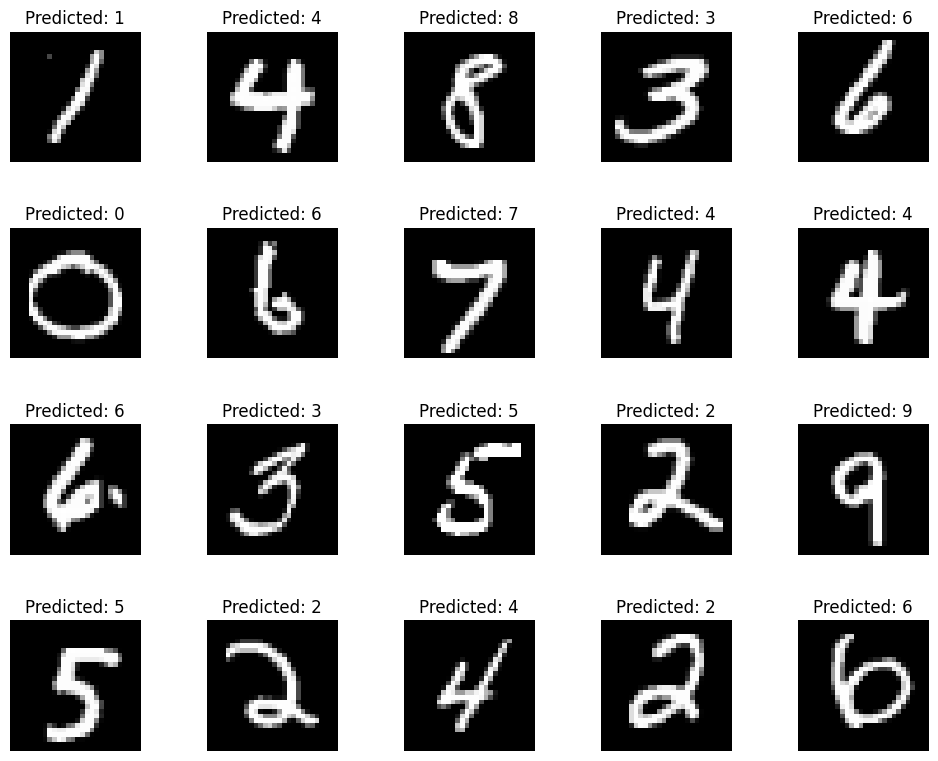

In [83]:
import matplotlib.pyplot as plt
import random

# Get 20 random indices from the test data
random_indices = random.sample(range(len(test_data)), 20)

# Create a figure to display the images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))
fig.tight_layout()

# Iterate over the random indices and plot the images
for i, index in enumerate(random_indices):
    # Get the image pixel values
    image_pixels = test_data.iloc[index].values.reshape(28, 28)

    # Get the predicted digit and probability from predictions_data
    predicted_digit = int(predictions_data.iloc[index]['Label'])
    

    # Plot the image
    ax = axes[i // 5, i % 5]
    ax.imshow(image_pixels, cmap='gray')
    ax.set_title(f"Predicted: {predicted_digit}")
    ax.axis('off')

plt.show()

In [86]:
predictions_data['Label']= predictions_data['Label'].astype('int64')

In [87]:
predictions_data.to_csv('predictions.csv', index=False)